In [5]:
#%%writefile rematch_df.py
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('ggplot')


import build_financial_df as fin
import build_results_df as res
import merge_df as mer

# get top 2 candidates from each race, leaving 13212 candidates total
# this step simplifies, but reduces info about third party candidates
top2_cand = mer.merge_df_cut.groupby('elec_id')['vote%'].nlargest(2)
# top2_cand is a pd.Series double-indexed by new_elec_id & merge_df_cut index no.


# make dictionary with values equal to set of names of top 2 candidates 
cand_pair_dct = {}
for pair in top2_cand.index:
    l_name = mer.merge_df_cut.loc[pair[1], 'last_name']
    if pair[0] not in cand_pair_dct:
        cand_pair_dct[pair[0]] = set()
    cand_pair_dct[pair[0]].add(l_name)

# list of sets of rematch races
from itertools import chain
rev_dict = {}
for key, value in cand_pair_dct.items():
    rev_dict.setdefault(str(value), set()).add(key)
rematch_list = [values for key, values in rev_dict.items() if len(values) > 1]

rematch_elec_id = []
for i in rematch_list:
    for x in i:
        rematch_elec_id.append(x)
        
# create dataframe of the 13212 'candidate entries' (bear in mind each candidate is in there at least twice)
index_list = [top2_cand.index[i][1] for i in range(len(top2_cand))]
rematch_df_start = mer.merge_df_start[mer.merge_df_start['elec_id'].isin(rematch_elec_id)]

'''

#use this to see how many races remain in dataset; this should be 
count_ttl = 0
for each in rematch_list:
    x = len(each)
    count_ttl += x
count_ttl
# first attempt, count_ttl is 1324
# second attempt, count_ttl is 1295... this makes sense because 

'''

rematch_cut = rematch_df_start[['FEC_ID','elec_id','year', 'candidate', 'candidatevotes', 
                                'vote%', 'office', 'party', 'state', 'district','INC_STATUS',
                                'totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

for i in range(len(rematch_list)):
    a = rematch_cut[rematch_cut['elec_id']==list(rematch_list[i])[0]].sort_values('FEC_ID').reset_index()
    b = rematch_cut[rematch_cut['elec_id']==list(rematch_list[i])[1]].sort_values('FEC_ID').reset_index()
    i1 = a['index'][0]
    i2 = a['index'][1]
    i3 = b['index'][0]
    i4 = b['index'][1]
    a.set_index('candidate')
    b.set_index('candidate')
    #print(a)
    #print(i1, i2, i3, i4)
    
    x = b['vote%']-a['vote%']
    # delta_vote for cand-idx0 in election a
    rematch_cut.loc[i1, 'delta_vote'] = 0
    # delta_vote for cand-idx1 in election a
    rematch_cut.loc[i2, 'delta_vote'] = 0
    # delta_vote for cand-idx0 in election b
    rematch_cut.loc[i3, 'delta_vote'] = x[0]
    # delta_vote for cand-idx1 in election b
    rematch_cut.loc[i4, 'delta_vote'] = x[1] 
    #print(x)
    y = b['TTL_DISB']-a['TTL_DISB']
    # delta_spend for cand-idx0 in election a
    rematch_cut.loc[i1, 'delta_spend'] = 0
    # delta_spend for cand-idx1 in election a
    rematch_cut.loc[i2, 'delta_spend'] = 0
    # delta_spend for cand-idx0 in election b
    rematch_cut.loc[i3, 'delta_spend'] = y[0]
    # delta_spend for cand-idx1 in election b
    rematch_cut.loc[i4, 'delta_spend'] = y[1] 
    #print(y)
    
rematch3 = rematch_cut[(~rematch_cut['delta_spend'].isna()) & (~rematch_cut['delta_vote'].isna())]
rematch4 = rematch3[rematch3['delta_vote']!= 0]
rematch4
#I expected 1374; I got 1208 entries 
# missing 166

/Users/Kelly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Kelly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,FEC_ID,elec_id,year,candidate,candidatevotes,vote%,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB,delta_vote,delta_spend
402,S8MN00024,1990-MN-SE,1990,Rudy Boschwitz,864375,47.81,US Senate,republican,Minnesota,statewide,I,1808045,6087588.00,6222333.00,40.83,6177669.00
403,S0MN00013,1990-MN-SE,1990,Paul David Wellstone,911999,50.44,US Senate,democrat,Minnesota,statewide,C,1808045,1401706.00,1380560.00,0.12,-4598664.00
415,S0NC00111,1990-NC-SE,1990,Harvey B. Gantt,981573,47.43,US Senate,democrat,North Carolina,statewide,NaN,2069585,7856827.00,7808470.00,1.51,-198796.00
416,S8NC00015,1990-NC-SE,1990,Jesse Helms,1087331,52.54,US Senate,republican,North Carolina,statewide,I,2069585,13376425.00,13425121.00,-0.10,5628646.00
512,S4VT00017,1992-VT-SE,1992,Patrick J. Leahy,154762,54.16,US Senate,democrat,Vermont,statewide,I,285739,935503.00,991831.00,-18.06,-17893.00
513,S2VT00110,1992-VT-SE,1992,James H. Douglas,123854,43.35,US Senate,republican,Vermont,statewide,NaN,285739,196635.00,195737.00,41.39,195737.00
533,S0HI00084,1994-HI-SE,1994,Daniel K. Akaka,256189,71.78,US Senate,democrat,Hawaii,statewide,I,356902,622945.00,421356.00,-4.27,310866.00
534,S8HI00012,1994-HI-SE,1994,Maria M. Hustace,86320,24.19,US Senate,republican,Hawaii,statewide,C,356902,29815.00,30272.00,2.47,-2067.00
610,S6CO00135,1996-CO-SE,1996,Tom Strickland,667600,45.74,US Senate,democrat,Colorado,statewide,O,1459601,3313065.00,3294906.00,44.22,3134401.00
611,S6CO00168,1996-CO-SE,1996,Wayne Allard,750315,51.41,US Senate,republican,Colorado,statewide,O,1459601,2198131.00,2233429.00,49.94,2219146.00


In [6]:
rematch_list

[{'1980-CA-09', '1982-CA-09'},
 {'1980-CA-11', '1982-CA-11'},
 {'1980-CA-36', '1982-CA-36', '1984-CA-36', '1988-CA-36'},
 {'1980-CA-37', '1992-CA-40', '1994-CA-40'},
 {'1980-CO-04', '2018-CA-44'},
 {'1980-CT-02', '1982-CT-02'},
 {'1980-CT-04', '1982-CT-04'},
 {'1980-IA-03', '1982-IA-03'},
 {'1980-IL-17', '1982-IL-04'},
 {'1980-IN-10', '1992-IN-02'},
 {'1980-KY-02', '1982-KY-02'},
 {'1980-MA-06', '1982-MA-06'},
 {'1980-MD-02', '1982-MD-02', '1984-MD-02'},
 {'1980-MI-06', '1982-MI-06', '1986-MI-06'},
 {'1980-MN-07', '1982-MN-07'},
 {'1980-NC-04', '1994-NJ-01'},
 {'1980-NC-05', '1982-NC-05'},
 {'1980-NE-02', '1982-NE-02'},
 {'1980-NJ-03', '1982-NJ-03'},
 {'1980-OH-05', '1982-OH-05', '1984-OH-05'},
 {'1980-OH-06', '1992-OH-06'},
 {'1980-OH-14', '1982-OH-14'},
 {'1980-OK-01', '1982-OK-01'},
 {'1980-OK-04', '1982-OK-04'},
 {'1980-PA-08', '1982-PA-08'},
 {'1980-PA-15', '1988-PA-15'},
 {'1980-TN-03', '1982-TN-03'},
 {'1980-TX-13', '1982-TX-13'},
 {'1980-TX-21', '1984-TX-21'},
 {'1980-UT-01', '

In [55]:
def get_rematch_table(idx):
    cand_rematch = mer.merge_df_cut[mer.merge_df_cut.loc[:, 'elec_id'].isin(rematch_list[idx])]
    return cand_rematch[['FEC_ID','elec_id','year', 'candidate', 'candidatevotes', 'office', 'party', 'state', 
                         'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

get_rematch_table(88)

,FEC_ID,elec_id,year,candidate,candidatevotes,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB
3839,H0CA11022,1986-CA-11,1986,Tom Lantos,112380,US House,democrat,California,11,I,151695,299231.0,325435.0
3840,H6CA11011,1986-CA-11,1986,"G. M. ""Bill"" Quraishi",39315,US House,republican,California,11,NaN,151695,69374.0,63996.0
4562,H0CA11022,1988-CA-11,1988,Tom Lantos,145484,US House,democrat,California,11,I,205016,386453.0,269510.0
4563,H6CA11011,1988-CA-11,1988,"G. M. ""Bill"" Quraishi",50050,US House,republican,California,11,NaN,205016,90306.0,95575.0
5281,H6CA11011,1990-CA-11,1990,Bill Quraishi,45818,US House,republican,California,11,NaN,159365,97638.0,97030.0
5282,H0CA11022,1990-CA-11,1990,Tom Lantos,105029,US House,democrat,California,11,I,159365,788298.0,646730.0


In [ ]:

'''
# eventually want to check (and filter out) for weirdos where total vote % > 100%
sum_vote_percent = merge_df_cut.groupby('new_elec_id')['vote%'].nlargest(2).sum(level=0)
# below attempt didn't work
sum_percent_df = pd.DataFrame()
sum_percent_df = sum_vote_percent[sum_vote_percent<=100]
merge_df_cut2 = merge_df_cut[merge_df_cut['new_elec_id'].isin(sum_percent_df.reset_index()['index'])]
merge_df_cut2
'''



In [3]:
rematch3 = rematch_cut[(~rematch_cut['delta_spend'].isna()) & (~rematch_cut['delta_vote'].isna())]
rematch4 = rematch3[rematch3['delta_vote']!= 0]
rematch4
#I expected 1374; I got 1208 entries 
# missing 166

,FEC_ID,elec_id,year,candidate,candidatevotes,vote%,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB,delta_vote,delta_spend
10189,H2ME02097,2002-ME-02,2002,Michael H. Michaud,116868,52.01,US House,democrat,Maine,2,O,224717,1185956.97,1172768.30,1.78,-125505.0
10198,H2MD06054,2002-MD-06,2002,Roscoe G. Bartlett,147825,66.17,US House,republican,Maryland,6,I,223400,188279.22,237994.85,-5.34,-282434.0
10509,H2TX27026,2002-TX-27,2002,Solomon P. Ortiz,68559,61.10,US House,democrat,Texas,27,I,112209,446120.76,559409.13,-41.64,-171500.0
10524,H2UT02167,2002-UT-02,2002,John Swallow,109123,48.69,US House,republican,Utah,2,C,224098,1167588.31,1163615.92,-10.90,-357910.0
14048,H6MD07160,2012-MD-07,2012,Elijah E. Cummings,247770,76.52,US House,democrat,Maryland,7,I,323818,795483.37,842134.99,10.69,594505.0
14053,H8MA05143,2012-MA-03,2012,Niki Tsongas,212119,63.30,US House,democrat,Massachusetts,3,I,335111,1606981.65,1477655.22,-3.54,-181055.0


In [10]:
def all_f(z):
    return  0.000004776*z + 0.3114

Text(0, 0.5, 'Change in Vote Point')

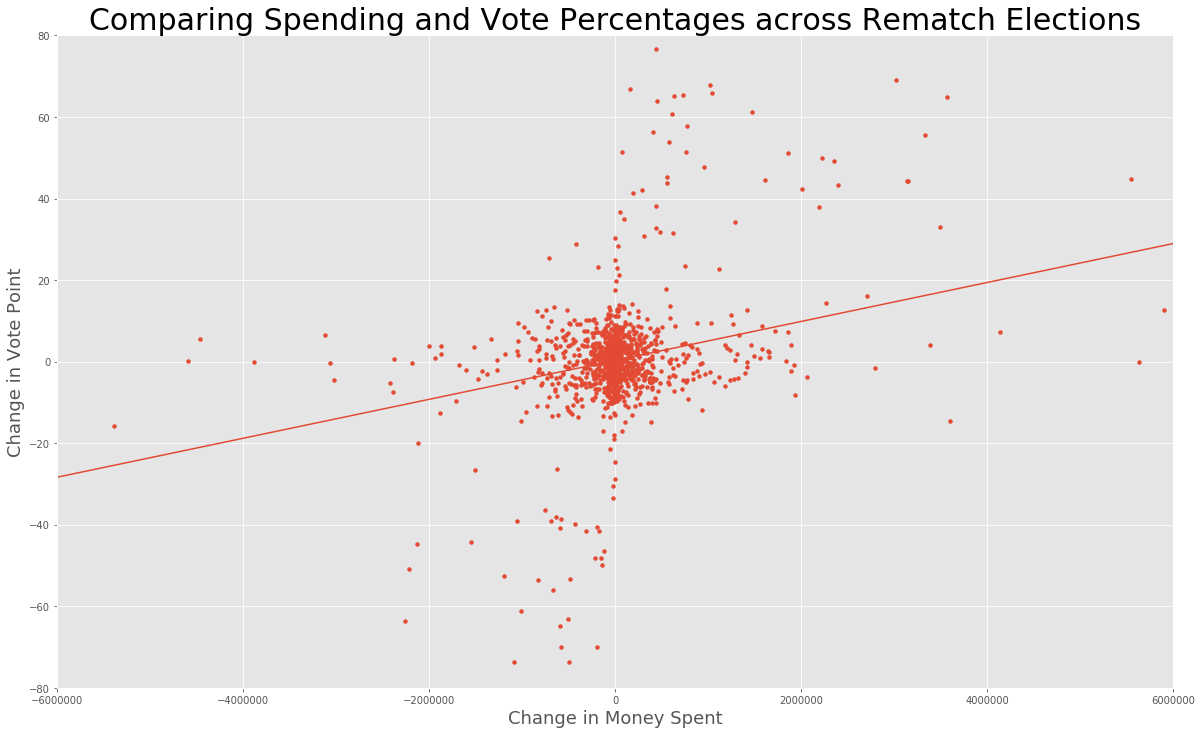

In [11]:
plot_all = rematch4[['delta_vote', 'delta_spend']]
x = plot_all['delta_vote']
y = plot_all['delta_spend']
fig, ax = plt.subplots(1, figsize=(20,12))
z = np.linspace(-6000000, 6000000, num=1200)
ax.plot(z, all_f(z), '-')
ax.scatter(y, x, alpha=1, s=15)
ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages across Rematch Elections', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=18)
ax.set_ylabel('Change in Vote Point', fontsize=18)

In [55]:
import statsmodels.api as sm
df = rematch4[['delta_vote', 'delta_spend']]
X = df['delta_spend']
y = df['delta_vote']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_vote   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     181.9
Date:                Sat, 01 Jun 2019   Prob (F-statistic):           1.01e-38
Time:                        08:08:36   Log-Likelihood:                -4789.8
No. Observations:                1208   AIC:                             9584.
Df Residuals:                    1206   BIC:                             9594.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3114      0.367      0.848      0.397      -0.409       1.032
delta_spend  4.776e-06   3.54e-07     13.489      0.000    4.08e-06    5.47e-06
==============================================================================
Omnibus:                      224.718   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4928.758
Skew:                           0.136   Prob(JB):                         0.00
Kurtosis:                      12.892   Cond. No.                     1.04e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
rematch_GOP = rematch4[rematch4['party']=='republican']
rematch_Dem = rematch4[rematch4['party']=='democrat']
rematch_Ind = rematch4[(rematch4['party']!='democrat') & (rematch3['party']!='republican')]

/Users/Kelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
def Ind_f(x):
    return  model_Ind.params[1]*x + model_Ind.params[0]
def Dem_f(x):
    return  model_Dem.params[1]*x + model_Dem.params[0]
def GOP_f(x):
    return  model_GOP.params[1]*x + model_GOP.params[0]

"\n#ax.tick_params(axis='x', pad=30) #move position of x-ticks and axis label\n\n"

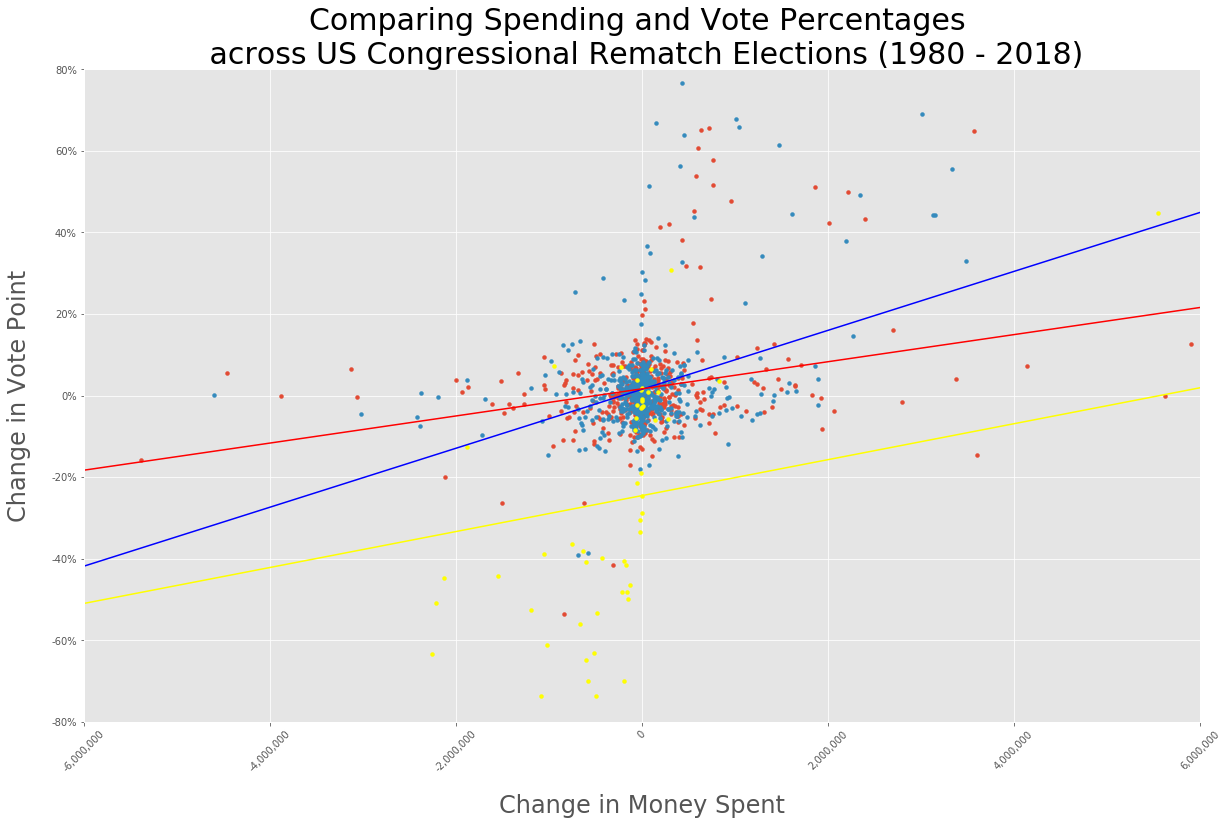

In [44]:
x1 = rematch_GOP['delta_vote']
y1 = rematch_GOP['delta_spend']
x2 = rematch_Dem['delta_vote']
y2 = rematch_Dem['delta_spend']
x3 = rematch_Ind['delta_vote']
y3 = rematch_Ind['delta_spend']

x = np.linspace(-6000000, 6000000, num=1200)




fig, ax = plt.subplots(1, figsize=(20,12))
ax.scatter(y1, x1, alpha=1, s=15)
ax.scatter(y2, x2, alpha=1, s=15)
ax.scatter(y3, x3, color='yellow', alpha=1, s=15)

# plot Ind line
ax.plot(x, Ind_f(x), '-', color='yellow')

# plot Dem line
ax.plot(x, Dem_f(x), '-', color='blue')

# plot GOP line
ax.plot(x, GOP_f(x), '-', color='red')


ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages \n across US Congressional Rematch Elections (1980 - 2018)', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=24)
ax.set_ylabel('Change in Vote Point', fontsize=24)
ax.xaxis.labelpad = 20 #move position of x-axis label, but not x ticks
ax.yaxis.labelpad = 20 #move position of x-axis label (but not y ticks)

#must add: import matplotlib.ticker as ticker
#
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

### next three lines make y labels into percentages
vals = ax.get_yticks()
percents = [x/100 for x in vals] #if already in decimal format, skip this
ax.set_yticklabels(['{:,.0%}'.format(x) for x in percents])

plt.xticks(rotation=45) #rotate x labels


'''
#ax.tick_params(axis='x', pad=30) #move position of x-ticks and axis label

'''

In [35]:
import statsmodels.api as sm
df_GOP = rematch_GOP[['delta_vote', 'delta_spend']]
X = df_GOP['delta_spend']
y = df_GOP['delta_vote']
X = sm.add_constant(X)
model_GOP = sm.OLS(y, X).fit()
predictions = model_GOP.predict(X)
model_GOP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_vote   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     73.39
Date:                Sat, 01 Jun 2019   Prob (F-statistic):           9.53e-17
Time:                        10:08:25   Log-Likelihood:                -2206.6
No. Observations:                 585   AIC:                             4417.
Df Residuals:                     583   BIC:                             4426.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6437      0.437      3.762      0.000       0.786       2.502
delta_spend  3.325e-06   3.88e-07      8.567      0.000    2.56e-06    4.09e-06
==============================================================================
Omnibus:                      317.347   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3663.959
Skew:                           2.142   Prob(JB):                         0.00
Kurtosis:                      14.488   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
import statsmodels.api as sm
df_Dem = rematch_Dem[['delta_vote', 'delta_spend']]
X = df_Dem['delta_spend']
y = df_Dem['delta_vote']
X = sm.add_constant(X)
model_Dem = sm.OLS(y, X).fit()
predictions = model_Dem.predict(X)
model_Dem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_vote   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     95.54
Date:                Sat, 01 Jun 2019   Prob (F-statistic):           5.79e-21
Time:                        10:08:59   Log-Likelihood:                -2177.9
No. Observations:                 571   AIC:                             4360.
Df Residuals:                     569   BIC:                             4368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5234      0.461      3.308      0.001       0.619       2.428
delta_spend  7.229e-06    7.4e-07      9.775      0.000    5.78e-06    8.68e-06
==============================================================================
Omnibus:                      354.610   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3889.101
Skew:                           2.596   Prob(JB):                         0.00
Kurtosis:                      14.684   Cond. No.                     6.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
import statsmodels.api as sm
df_Ind = rematch_Ind[['delta_vote', 'delta_spend']]
X = df_Ind['delta_spend']
y = df_Ind['delta_vote']
X = sm.add_constant(X)
model_Ind = sm.OLS(y, X).fit()
predictions = model_Ind.predict(X)
model_Ind.summary()
print("Coefficients:")
print(model.params, "\n")
print("P-values for coefficients:")
print(model.pvalues)

Coefficients:
const          1.643669
delta_spend    0.000003
dtype: float64 

P-values for coefficients:
const          1.856863e-04
delta_spend    9.527913e-17
dtype: float64


-24.54488861697856